### Four classifications of brain tumor in the MRI dataset:

### **1. Glioma**  
Gliomas are tumors that originate in the **glial cells** of the brain or spinal cord. Glial cells are supportive cells that surround and protect neurons. Gliomas can be highly aggressive and vary in severity. They are classified into several subtypes based on the type of glial cell involved, such as **astrocytomas**, **oligodendrogliomas**, and **glioblastomas**.  
- **Common locations**: Cerebral hemispheres  
- **Symptoms**: Headache, seizures, memory loss, and motor weakness  
- **MRI Characteristics**: Irregular, diffuse mass with varying contrast enhancement depending on the grade.

### **2. Meningioma**  
Meningiomas are tumors that arise from the **meninges**, the protective layers covering the brain and spinal cord. Most meningiomas are benign (non-cancerous), but some can be atypical or malignant. They are slow-growing and often asymptomatic in the early stages.  
- **Common locations**: Near the surface of the brain, close to the meninges  
- **Symptoms**: Headaches, vision problems, and neurological deficits  
- **MRI Characteristics**: Well-defined, extra-axial mass (outside brain tissue) with strong contrast enhancement and a “dural tail” sign.

### **3. No Tumor**  
This category refers to **healthy brain MRIs** or those without any visible tumor. These scans serve as a control group in the dataset and are essential for training machine learning models to distinguish between normal and abnormal brain images.  
- **Common appearance**: Normal brain structure without any mass or abnormal enhancement.

### **4. Pituitary Tumor**  
Pituitary tumors are abnormal growths in the **pituitary gland**, a small gland at the base of the brain responsible for hormone regulation. Most pituitary tumors are benign adenomas, but they can still cause significant health problems by affecting hormone levels or pressing on nearby structures, such as the optic nerves.  
- **Common locations**: Sella turcica (bony structure at the brain's base)  
- **Symptoms**: Hormonal imbalances, vision problems, and headaches  
- **MRI Characteristics**: Well-circumscribed lesion in the sellar region, often enhancing with contrast.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports Libraries

In [ ]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageEnhance  # For image processing and enhancement

from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from tensorflow.keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array



from sklearn.utils import shuffle  # For shuffling the data
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

**Brain tumor: Least to Most Severe stages**
- Notumor (No tumor, healthy)
- Meningioma (Benign, slow-growing)
- Pituitary (Intermediate, hormone-related)
- Glioma (Aggressive, malignant)

## Load Datasets

In [ ]:
# Directories for training and testing data
train_dir = '/content/drive/MyDrive/Colab Notebooks/datasets/brain_mri_dataset/Training'
test_dir = '/content/drive/MyDrive/Colab Notebooks/datasets/brain_mri_dataset/Testing'

In [ ]:
train_paths = []
train_labels = []
for label in os.listdir(train_dir): # checking all classification names
    print(label)

glioma
meningioma
notumor
pituitary


In [ ]:
# Load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

#print(train_paths)
#print(train_labels)

In [ ]:
# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

#print(test_paths)
#print(test_labels)

## Data Visualization

In [ ]:
# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)
# print(random_indices)

# Create a figure to display images in 2 rows
# fig, axes = plt.subplots(2, 5, figsize=(15, 8))
# axes = axes.ravel()
# print(fig, axes)

for i, idx in enumerate(random_indices):
    print(i,idx)

0 2195
1 3844
2 5007
3 550
4 3936
5 151
6 4159
7 2703
8 3749
9 653


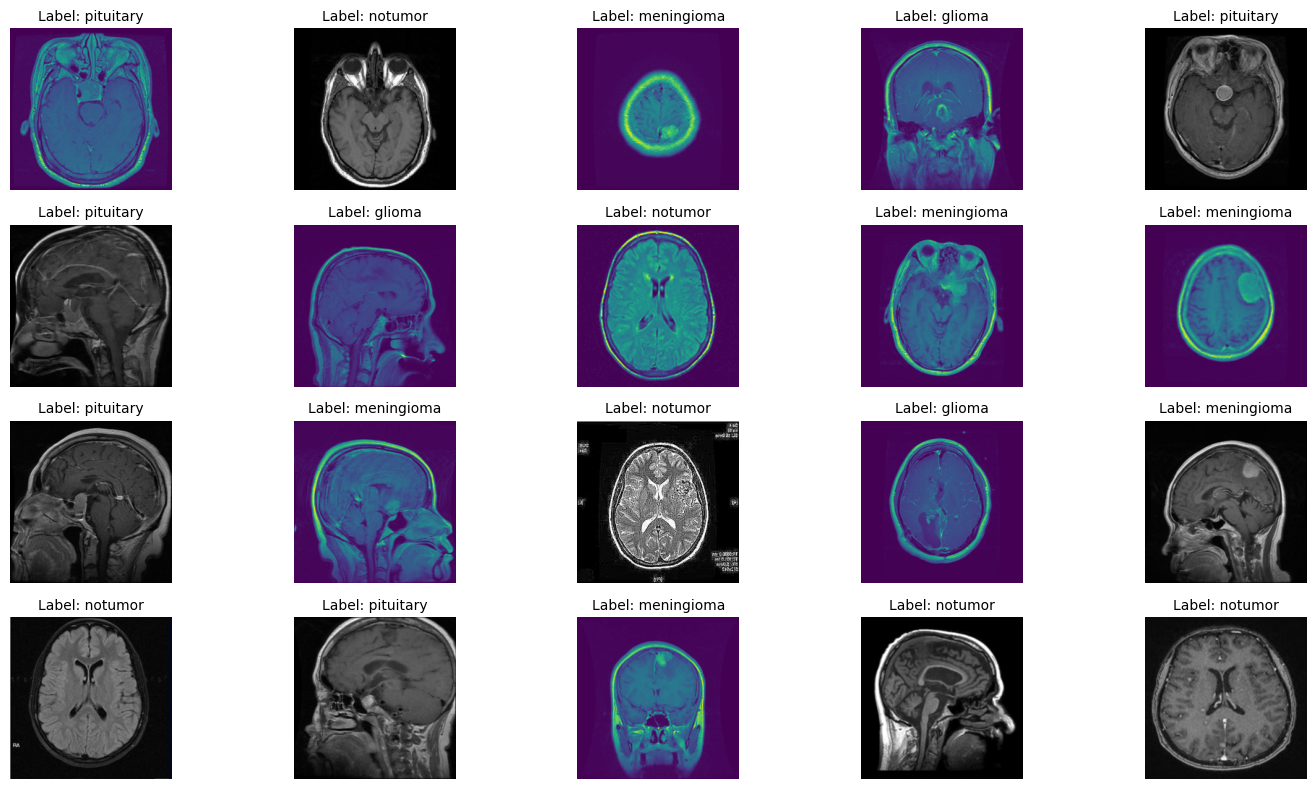

In [ ]:
# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 20)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(4, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis

    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

## Image Preprocessing

In [ ]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))  # Convert NumPy array to PIL image
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Convert PIL image back to NumPy array and normalize to [0, 1]
    return image

In [ ]:
# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))  # Load image with target size
        image = augment_image(image)  # Apply augmentation
        images.append(image)  # Append augmented image to list
    return np.array(images)  # Return images as NumPy array

In [ ]:
# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]  # Convert labels to integers
    return np.array(encoded)

In [ ]:
# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):  # Loop through the specified number of epochs
        for i in range(0, len(paths), batch_size):  # Iterate over data in batches
            batch_paths = paths[i:i + batch_size]  # Select batch of image paths
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]  # Select corresponding labels
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch (images, labels)

## Model Training

In [ ]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
CHANNELS = 3
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,763,908 (60.13 MB)

 Trainable params: 8,128,644 (31.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [ ]:
# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 5

In [ ]:
# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1496s 5s/step - loss: 0.6905 - sparse_categorical_accuracy: 0.7292
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 41s 113ms/step - loss: 0.2598 - sparse_categorical_accuracy: 0.9062
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 32s 114ms/step - loss: 0.1595 - sparse_categorical_accuracy: 0.9357
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - loss: 0.1263 - sparse_categorical_accuracy: 0.9492
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - loss: 0.0922 - sparse_categorical_accuracy: 0.9668


In [ ]:
model.save("mri_brain_model.h5")

## model plot

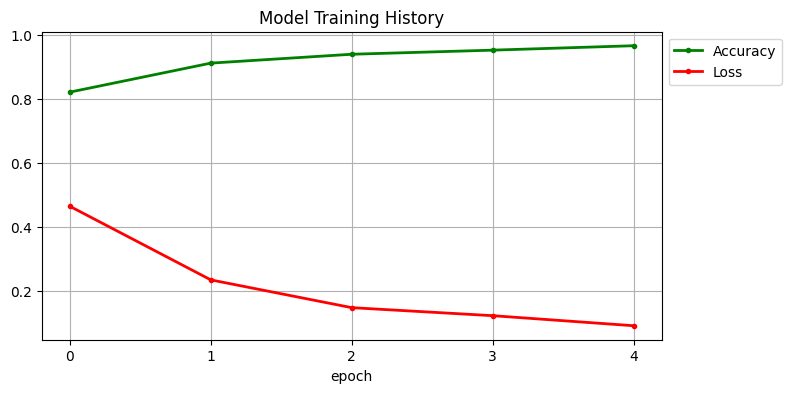

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

## Model Classifation Reports

In [ ]:
# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 216ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83       300
           1       0.79      0.93      0.86       306
           2       0.99      0.98      0.99       405
           3       0.88      0.99      0.93       300

    accuracy                           0.91      1311
   macro avg       0.92      0.90      0.90      1311
weighted avg       0.92      0.91      0.91      1311



## Model Confusion Plot

Confusion Matrix:
[[214  64   1  21]
 [  1 284   1  20]
 [  0   8 397   0]
 [  0   2   0 298]]


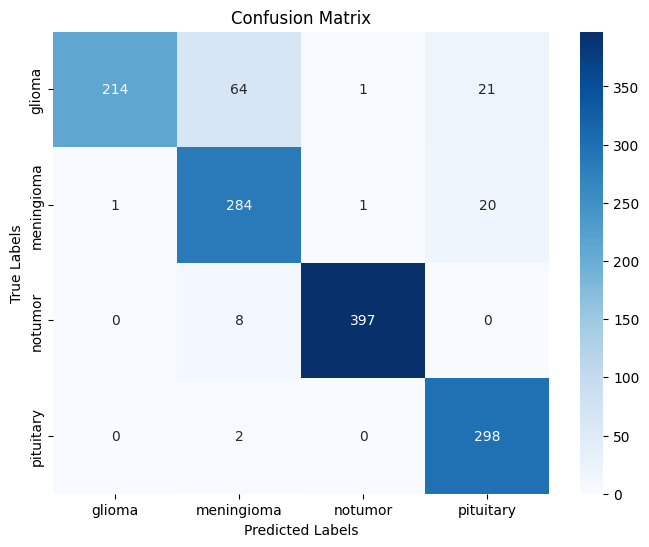

In [ ]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Roc Curve Plot

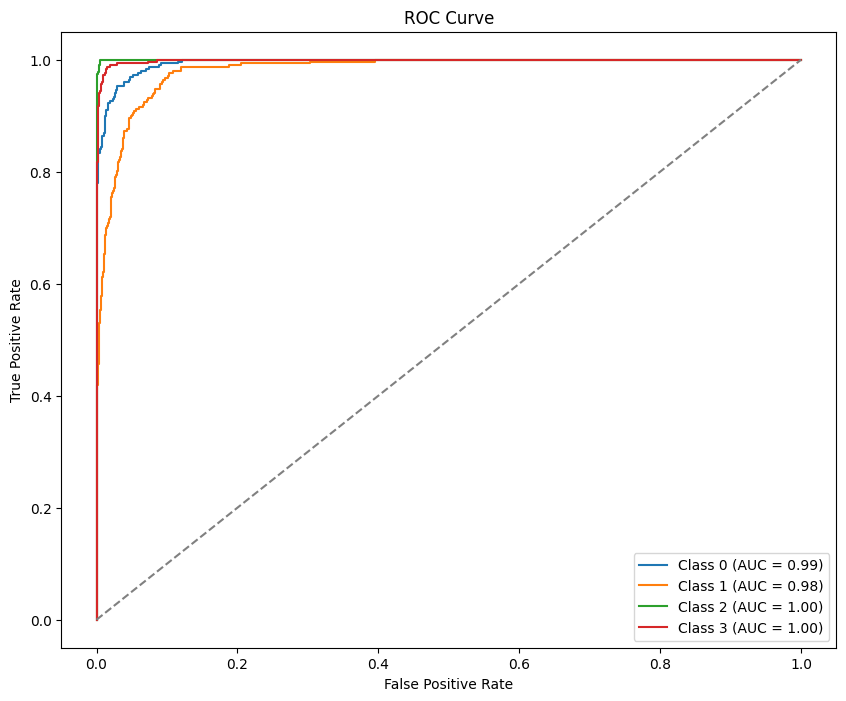

In [ ]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

## MRI Tumor Detection System

In [ ]:
# Load the trained model
model = load_model('/content/mri_brain_model.h5')

In [ ]:
# Class labels
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


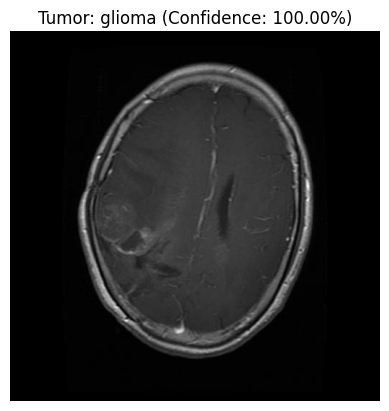

In [ ]:
# Example of glioma
image_path = '/content/drive/MyDrive/Colab Notebooks/datasets/brain_mri_dataset/Testing/glioma/Te-gl_0035.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


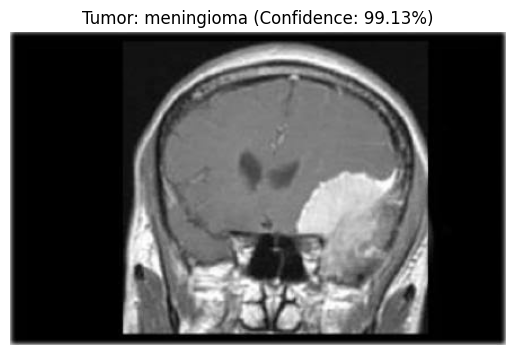

In [ ]:
# Example of meningioma
image_path = '/content/drive/MyDrive/Colab Notebooks/datasets/brain_mri_dataset/Testing/meningioma/Te-meTr_0000.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


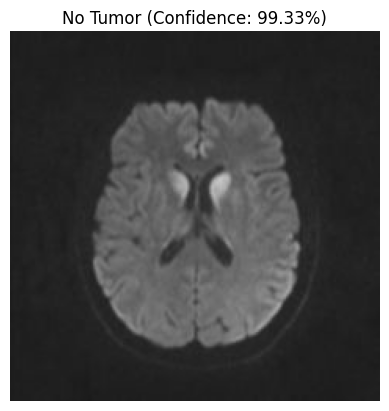

In [ ]:
# Example of no tumor
image_path = '/content/drive/MyDrive/Colab Notebooks/datasets/brain_mri_dataset/Testing/notumor/Te-noTr_0007.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


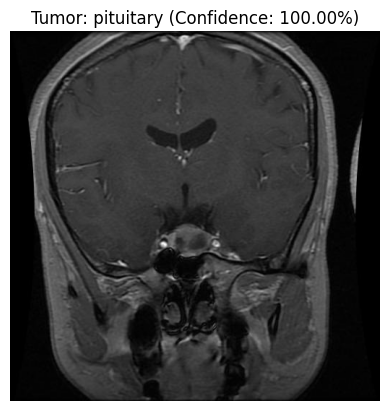

In [ ]:
# Example of pituitary
image_path = '/content/drive/MyDrive/Colab Notebooks/datasets/brain_mri_dataset/Testing/pituitary/Te-pi_0051.jpg'
detect_and_display(image_path, model)